# Linear regression models for predicting pollution

The [NO2 dataset](https://www.openml.org/d/547) contains 500 measurement of pollution caused by cars. The goal is to predict the concentration of $NO_2$ from data about traffic and atmospheric conditions. The predictive variables include the number of cars per hour, temperature, wind, and time of day.

# Janaki Sajja
# EAI6000
# 02-29-2020

# Additional coding work that I have done which is different from the given solution.
* For the question 1.1, the logic I used was slightly different from the given solution. Instead of assigining test and train scores to different variables and returing them, I had directly returned the list of test and train scores in the function evaluate_learners().
* For the question 2.1, the logic I used differs from the give solution. I have changed the X and Y labels of the graph and tried to change the plotting.Also, calculated the best alpha values in the graph and labelled it as Y label of the graph.
* For question 3.1, the code here differs from the code provided in the solution. Also, I have considered the scatter coefficients of best alpha.
* For questions, 3.1 and 3.2 the graphical visualization I presented is different from the solution.

In [1]:
# General imports
import warnings
warnings.filterwarnings("ignore")
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
from matplotlib import cm
import matplotlib.pyplot as plt
import openml as oml

In [2]:
plt.style.use("seaborn")
%matplotlib inline

In [3]:
# Download NO2 data. Takes a while the first time.
no2 = oml.datasets.get_dataset(547)
X, y, _, attribute_names = no2.get_data(target=no2.default_target_attribute); 

## Quick visualization
We can use pandas to quickly visualize the data. If you are new to pandas, take some time to understand the code.

We'll remove the 'day' feature to focus on the non-temporal aspects of this interaction. We are not aiming to predict future levels, and even if we would it would require special treatment (e.g. different train-test splits). There also doesn't seem to be a long term trend in the data, even though there are clear periodic trends in temperature.

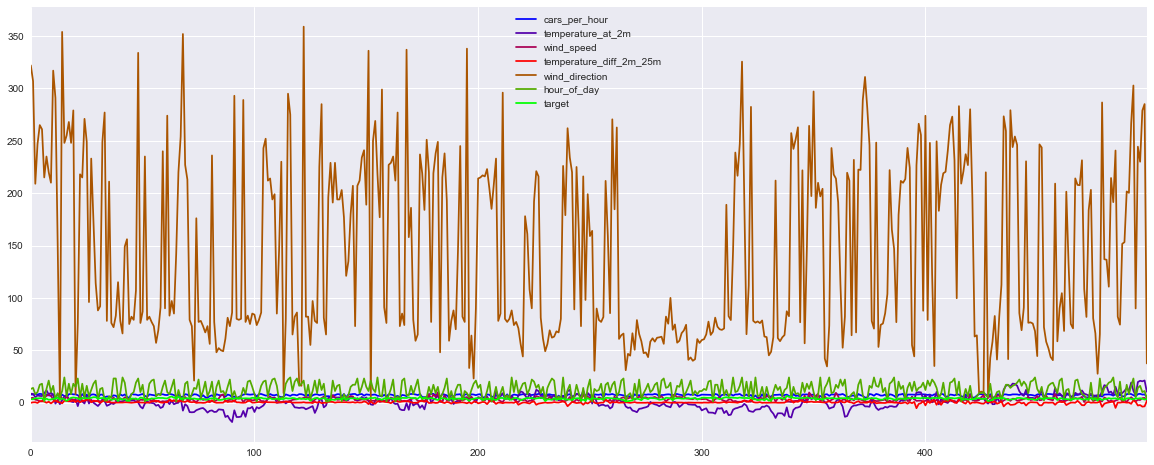

In [4]:
df = pd.DataFrame(X, columns=attribute_names).join(pd.DataFrame(list(y),columns=['target']))
df = df.sort_values(['day','hour_of_day']).drop('day',axis=1)
df.plot(use_index=False,figsize=(20,8),cmap=cm.get_cmap('brg'));
X = X.drop('day',axis=1)

In [5]:
df.head()

,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,target
42,7.64,8.5,4.3,-0.2,322.0,13,3.22
20,7.75,8.2,4.5,0.2,307.0,14,3.15
255,8.12,5.2,2.8,0.3,209.0,8,4.20
488,7.64,6.7,2.3,-0.4,247.0,10,3.98
94,8.32,6.3,1.2,1.3,265.0,17,4.14


If we plot the data, ordered by time of measurement, we can see that the wind direction (measured in angular degrees) is scaled very differently from the other features. Let's now zoom in to the other measures:

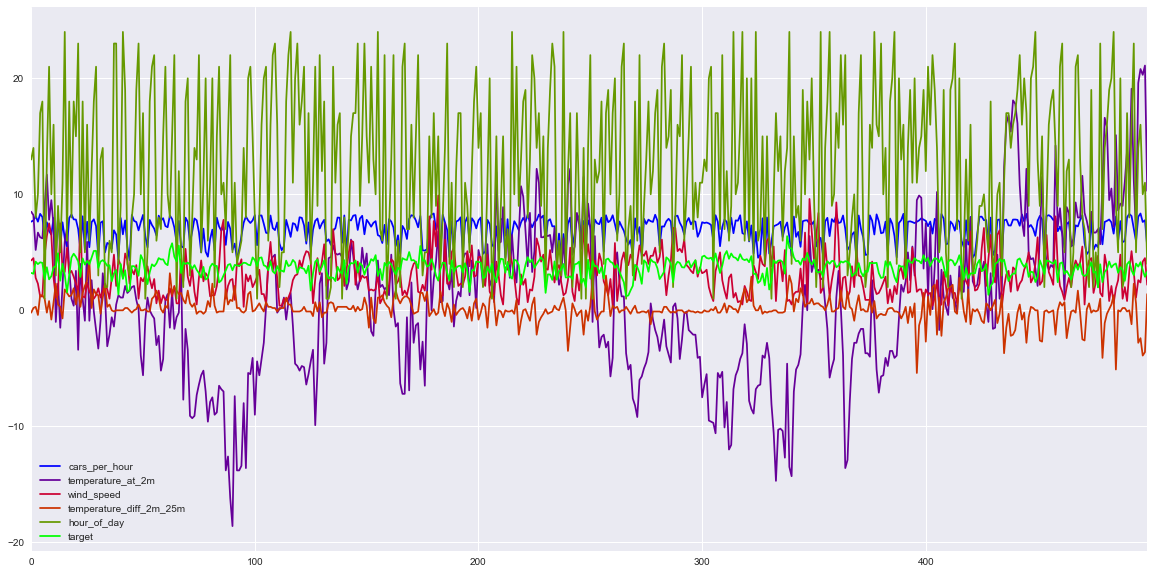

In [6]:
df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,10),cmap=cm.get_cmap('brg'));

We can see that the target ($NO_2$ levels) seem to be correlated to the number of cars per hour, which makes sense because cars produce $NO_2$. Other influences (air temperature differences and wind) seem to have a more complex and subtle effect. Let's try to model these using linear regression models.

## Exercise 1: Model benchmark
It is clear that $NO_2$ concentrations depend on a combination of these features, so we will now try to learn this complex relationship. We first evaluate a range of linear regression problems, i.e. Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN. Since we observed that somf features have very different scales, we'll also build pipelines of all these measures with an additional scaling step. For now, we'll stick to the default hyperparameter settings. 

### Exercise 1.1
Implement a function below which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You are allowed to import additional functions from whichever module you like, but you should be able to complete the function with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. Below you the function you will find example output.

In [7]:
from sklearn.model_selection import cross_validate


def evaluate_learners(models, X, y):
    """     
    Given a list of models [model1, model2, ..., modelN] return two lists:
     - a list with the scores obtained on the training samples for each model,
     - a list with the test scores obtained on the test samples for each model.
     The order of scores should match the order in which the models were originally provided. E.g.:     
     [Model1 train score, ..., ModelN train score], [Model1 test score, ..., ModelN test score]
    """
    cross_validations = [cross_validate(model, X, y, return_train_score=True) for model in models]

    return (
        list(map(lambda x: x["train_score"], cross_validations)),
        list(map(lambda x: x["test_score"], cross_validations))
    )


### Exercise 1.2
Call the function you created with a Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

In [8]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.neighbors import KNeighborsRegressor


models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), KNeighborsRegressor()]

train_scores, test_scores = evaluate_learners(models, X, y)

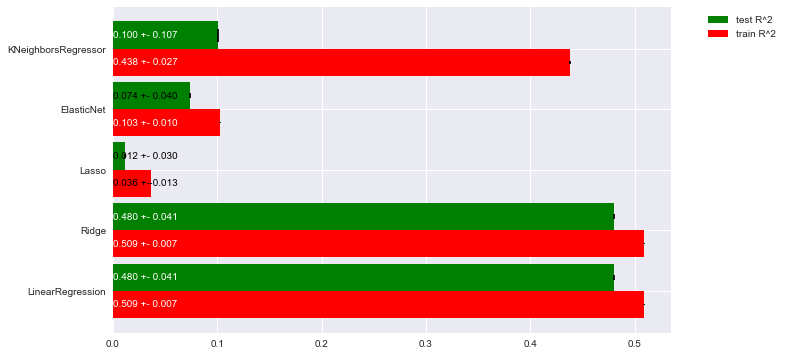

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
width=0.45

ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test R^2')

ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train R^2')

for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.3f} +- {:.3f}".format(np.mean(te),np.std(te)), color=('white' if np.mean(te)>0.1 else 'black'), va='center')
    ax.text(0, i-width, "{:.3f} +- {:.3f}".format(np.mean(tr),np.std(tr)), color=('white' if np.mean(tr)>0.1 else 'black'), va='center')
    
labels = [c.__class__.__name__ if not hasattr(c, 'steps') else c.steps[0][0] + "_" + c.steps[1][0] for c in models]
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3
Interpret the plot. Which is the best regressor? Are any of the models overfitting? If so, what can we do to solve this? Is there a lot of variance in the results?

# Answer
According to the visualisation LinearRegression and RidgeRegression are the best fitted models (note, that we used models with the default settings).
kNN is overfitted.

Lasso and ElasticNet showed bad results.

## Exercise 2: Regularization 
We will now tune these algorithm's main regularization hyperparameter: the regularization hyperparameter (`alpha`) in Lasso and Ridge, and the number of neighbors (`n_neighbors`) in kNN.

We expect the optimum for the alpha parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. alpha should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]), n_neighbors should be varied uniformly (i.e. [1,2,3,4]).

### Exercise 2.1
Vary the hyperparameters in the range given above and, for each regressor, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each regressor. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.

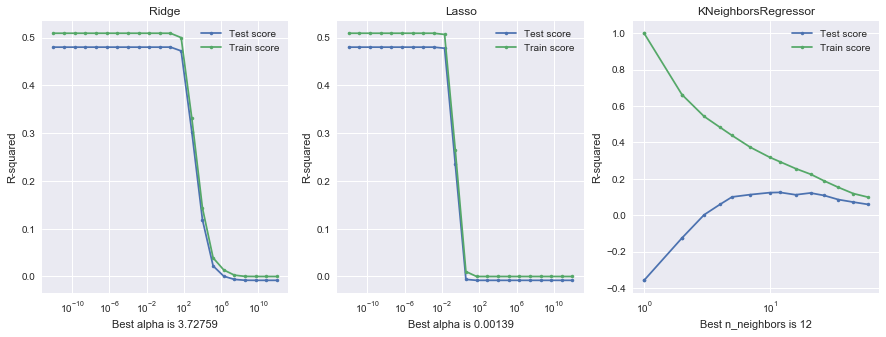

In [10]:
from sklearn.model_selection import GridSearchCV

params = [
    {"alpha": np.logspace(-12, 12, num=22)},
    {"alpha": np.logspace(-12, 12, num=22)},
    {"n_neighbors": np.geomspace(1, 60, num=17, dtype=int)[1:]}
]
models = [Ridge(), Lasso(), KNeighborsRegressor()]

grid_searches = [
    GridSearchCV(model, param, return_train_score=True).fit(X, y) 
    for model, param in zip(models, params)
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for gs, param, ax in zip(grid_searches, params, axes):
    param_name = next(iter(param))
    ax.plot(gs.param_grid[param_name], gs.cv_results_['mean_test_score'], label = 'Test score', marker = '.')
    ax.plot(gs.param_grid[param_name], gs.cv_results_['mean_train_score'], label = 'Train score', marker = '.')
    ax.set_ylabel('R-squared')
    ax.set_xlabel(f"Best {param_name} is {np.round(gs.best_params_[param_name], 5)}")
    ax.set_title(gs.best_estimator_.__class__.__name__)
    ax.legend()
    
    ax.set_xscale('log')

### Exercise 2.2
Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

# Answer
For Ridge regression the best value is ~3.73 for alpha regularization parameter, if the value is greater than the model is getting overfitted

For Lasso regression best alpha is 0.00139

Comparing Ridge and Lasso, Ridge is less sensetive to alpha tuning than Lasso

For kNN best number of neighbors is around 12

### Exercise 2.3
ElasticNet allows to mix L1 and L2 loss, and the `l1_ratio` hyperparameter defines the ratio of L1 loss. Hence, it has two interacting hyperparameters: l1_ratio and alpha. Run a grid search to obtain a matrix of l1_ratio and alpha values and the resulting cross-validation scores. Then, use the function provided below to plot a heatmap of all values and interpret the result. Can you explain how the two hyperparameters interact?

In [11]:
# Generic heatmap
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values
    
    values: nxn array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

In [12]:
elastic_params = {"l1_ratio": np.linspace(0, 1, num=11), "alpha": np.logspace(-12, 12, num=25)}
grid_search = GridSearchCV(ElasticNet(), elastic_params, return_train_score=True).fit(X,y)

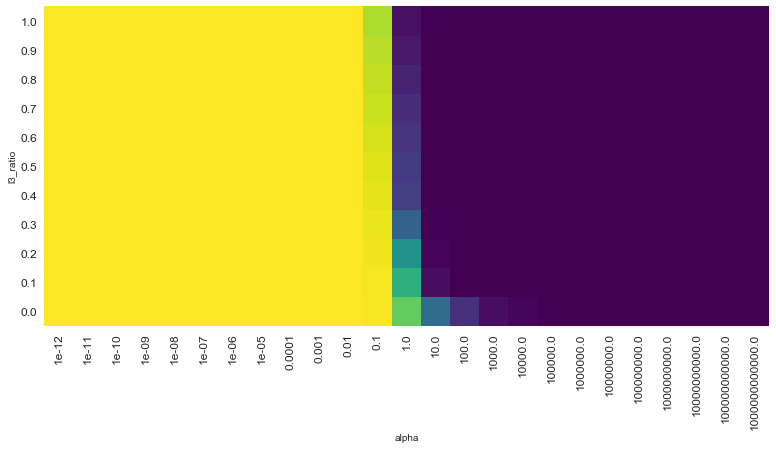

In [13]:
scores = grid_search.cv_results_["mean_test_score"].reshape(25,11).T
fig, axes = plt.subplots(1, 1, figsize=(13, 13))
heatmap(
    scores,
    xlabel="alpha",
    xticklabels=elastic_params['alpha'],
    ylabel="l3_ratio", yticklabels=np.around(elastic_params['l1_ratio'],4),
    cmap="viridis", 
    fmt="%.2f", 
    ax=axes
)
plt.show()

## Exercise 3: Visualizing coefficients
Finally, let's verify whether the different optimized linear models also find the same coefficients. 

### Exercise 3.1
Draw a [scatterplot](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) plotting the coefficients of the different models in different colors. Do you see much difference between the different models?

For all models, choose an alpha parameter that seems to work well in the previous exercise. When in doubt, use alpha=0.001.

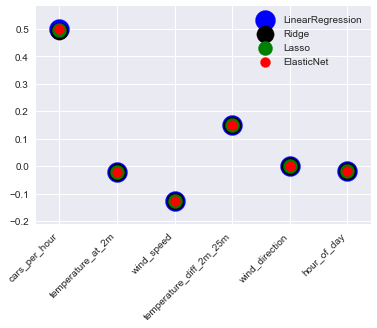

In [14]:
def scatter_coefficients(alpha=0.001, best_alphas=None):
    if best_alphas is None:
        models = [LinearRegression(), Ridge(alpha=alpha), Lasso(alpha=alpha), ElasticNet(alpha=alpha)]
    else:
        models = [LinearRegression(), Ridge(alpha=best_alphas[0]), Lasso(alpha=best_alphas[1]), ElasticNet(alpha=best_alphas[2])]
        
    coeff = [m.fit(X,y).coef_ for m in models]
    attribute_names = list(X)
    col = ["b", "k", "g", "r"]
    plt.figure()
    plt.xticks(rotation=45, ha="right")
    
    for i in range(0,4):
        plt.scatter(
            attribute_names, 
            coeff[i], 
            s=(4-i)*100, 
            c=col[i], 
            label=models[i].__class__.__name__
        )
        
    plt.legend()
    
scatter_coefficients(best_alphas=(3.727, 0.0013, 0.001))

All features could be predicted with the same coefficient over different models with their best coefficients. ars_per_hour is the most influential, followed by temperature_diff_2m_25m and wind_speed. The others are nearly zero.

### Exercise 3.2
Redraw the same plot but now using a large amount of regularization (e.g. alpha=1). What do you observe? Does this help you explain the performance difference between Ridge and Lasso in exercise 1.2? 

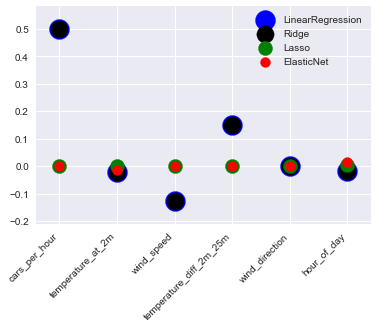

In [15]:
scatter_coefficients(alpha=1)

With alpha coeff 1 Lasso showed a greater performance than Ridge. Increasing alpha makes Lasso completely ignore most features: the coefficients are exactly 0. Hence, it is important to tune alpha carefully.